In [4]:
# ============================================================================
# CELL 1: Import Required Libraries
# ============================================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  2
TensorFlow version: 2.18.0


In [5]:
# ============================================================================
# CELL 2: Set Directory Path
# ============================================================================
sdir = '/kaggle/input/dog-and-cat-classification-dataset/PetImages'

print(f"Dataset directory: {sdir}")
print(f"Directory exists: {os.path.exists(sdir)}")

# Check the classes
if os.path.exists(sdir):
    classes_found = [d for d in os.listdir(sdir) if os.path.isdir(os.path.join(sdir, d))]
    print(f"Classes found: {classes_found}")
    
    # Count images in each class
    for cls in classes_found:
        cls_path = os.path.join(sdir, cls)
        num_images = len([f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  {cls}: {num_images} images")

Dataset directory: /kaggle/input/dog-and-cat-classification-dataset/PetImages
Directory exists: True
Classes found: ['Dog', 'Cat']
  Dog: 12499 images
  Cat: 12499 images


In [8]:
# ============================================================================
# CELL 3: Clean Dataset (Remove Corrupted Images)
# ============================================================================
print("\nChecking for corrupted images...")

corrupted_files = []
for klass in os.listdir(sdir):
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        print(f"Checking {klass} folder...")
        for f in flist:
            fpath = os.path.join(classpath, f)
            try:
                img = Image.open(fpath)
                img.verify()
            except:
                corrupted_files.append(fpath)

if corrupted_files:
    print(f"\nFound {len(corrupted_files)} corrupted images.")
    print("We'll skip them when creating the dataframe.")
else:
    print("\nNo corrupted images found!")



Checking for corrupted images...
Checking Dog folder...
Checking Cat folder...

No corrupted images found!


In [9]:
# ============================================================================
# CELL 4: Create DataFrame from Directory Structure
# ============================================================================
print("\nCreating dataframe from directory structure...")
filepaths = []
labels = []

classlist = os.listdir(sdir)
print(f"Classes found: {classlist}")

for klass in classlist:
    classpath = os.path.join(sdir, klass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            if fpath not in corrupted_files:
                if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                    filepaths.append(fpath)
                    labels.append(klass)

# Create DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

print("\nDataFrame Head:")
print(df.head())
print("\nClass Distribution:")
print(df['labels'].value_counts())
print(f"\nTotal valid images: {len(df)}")



Creating dataframe from directory structure...
Classes found: ['Dog', 'Cat']

DataFrame Head:
                                           filepaths labels
0  /kaggle/input/dog-and-cat-classification-datas...    Dog
1  /kaggle/input/dog-and-cat-classification-datas...    Dog
2  /kaggle/input/dog-and-cat-classification-datas...    Dog
3  /kaggle/input/dog-and-cat-classification-datas...    Dog
4  /kaggle/input/dog-and-cat-classification-datas...    Dog

Class Distribution:
labels
Dog    12499
Cat    12499
Name: count, dtype: int64

Total valid images: 24998


In [10]:
# ============================================================================
# CELL 5: Split Data into Train, Validation, and Test Sets
# ============================================================================
train_split = 0.8
test_split = 0.1
dummy_split = test_split / (1 - train_split)

train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

print(f'\ntrain_df length: {len(train_df)}')
print(f'test_df length: {len(test_df)}')
print(f'valid_df length: {len(valid_df)}')


train_df length: 19998
test_df length: 2500
valid_df length: 2500


In [11]:
# ============================================================================
# CELL 6: Create Image Data Generators
# ============================================================================
height = 128  # Reduced from 224 for faster training from scratch
width = 128
channels = 3
batch_size = 64  # Increased batch size for better gradient estimates
img_shape = (height, width, channels)
img_size = (height, width)

# Calculate test batch size
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) 
                          if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print(f'\nTest batch size: {test_batch_size}')
print(f'Test steps: {test_steps}')

# Training generator with aggressive data augmentation (helps when training from scratch)
train_gen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_gen = train_gen_augmented.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Validation generator (no augmentation)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

# Test generator (no augmentation, no shuffle)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

classes = list(train_gen.class_indices.keys())
class_count = len(classes)
print(f'\nClasses: {classes}')
print(f'Number of classes: {class_count}')


Test batch size: 50
Test steps: 50
Found 19998 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.

Classes: ['Cat', 'Dog']
Number of classes: 2



Showing sample training images...


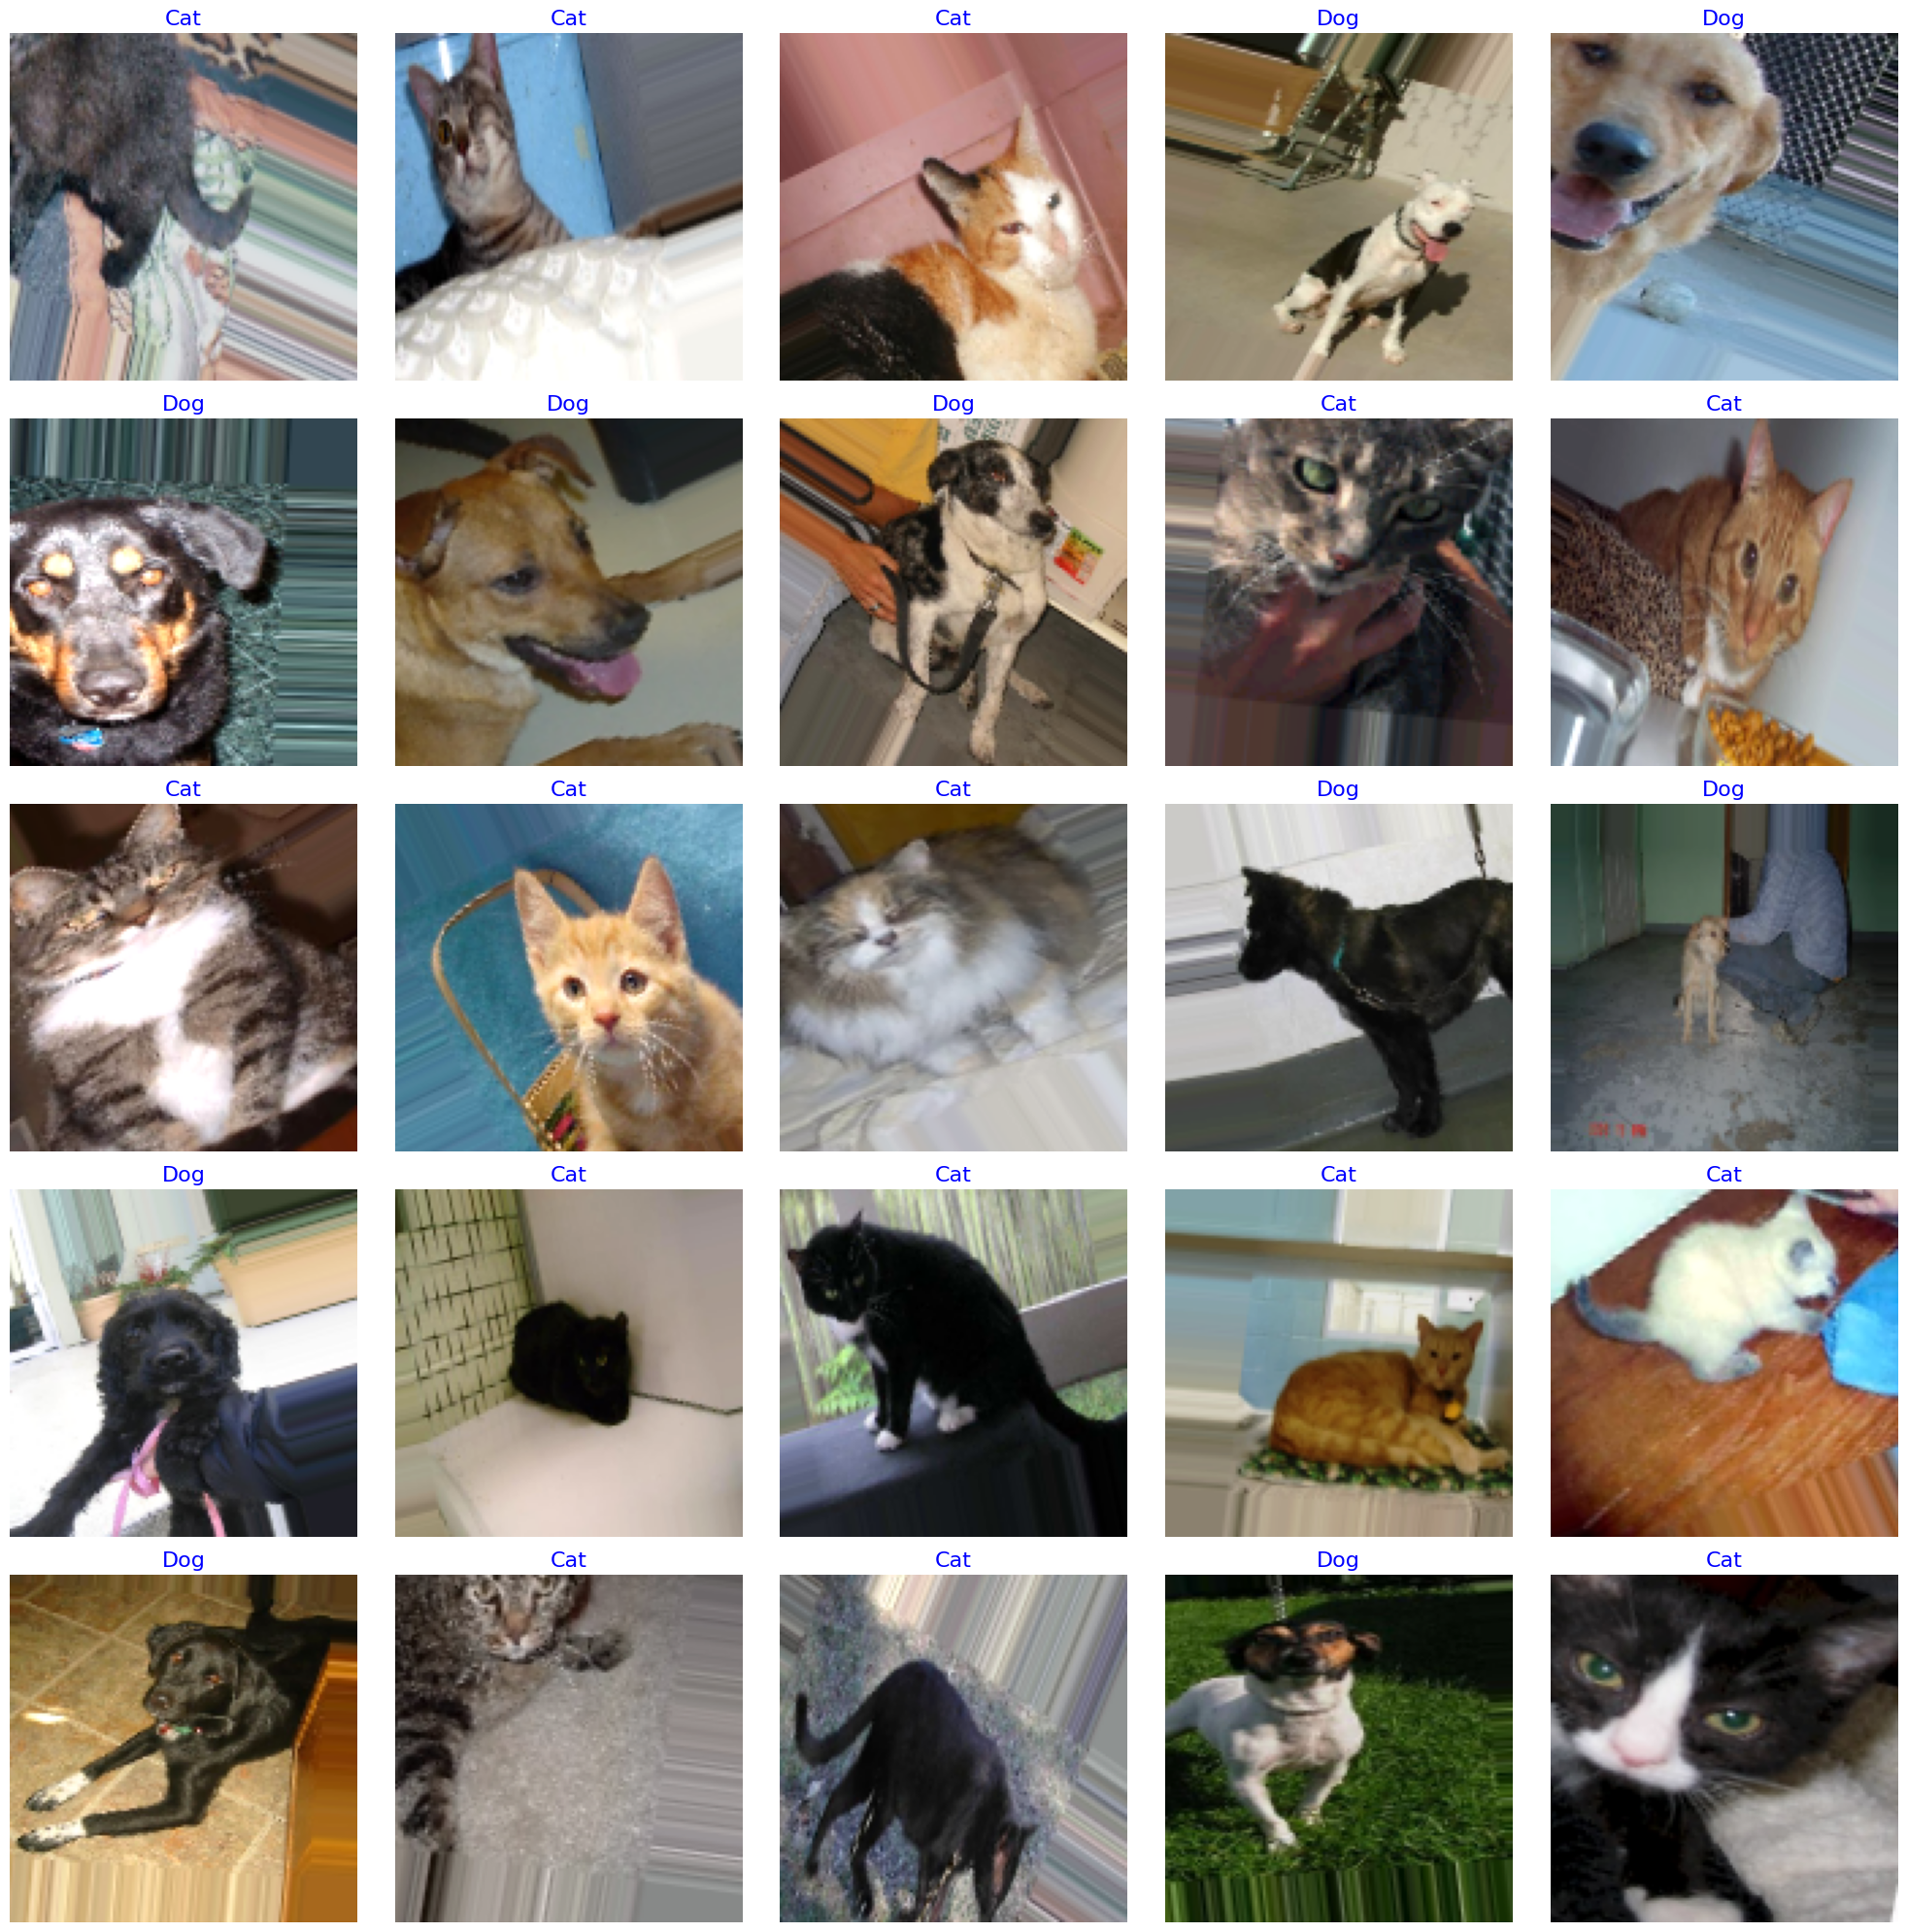

In [12]:
# ============================================================================
# CELL 7: Visualize Sample Images
# ============================================================================
def show_image_samples(gen):
    """Display sample images from the generator"""
    test_dict = test_gen.class_indices
    classes = list(test_dict.keys())
    images, labels = next(gen)
    
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)
    
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nShowing sample training images...")
show_image_samples(train_gen)


In [14]:
# ============================================================================
# CELL 8: Build Custom CNN Model From Scratch
# ============================================================================
print("\nBuilding CNN model from scratch...")
print("Architecture: Custom CNN with 5 Convolutional Blocks")

model_name = 'DogCat_Custom_CNN'

# Build the model
model = Sequential([
    # Input layer
    Input(shape=(128, 128, 3)),
    
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Block 4
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Block 5
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Flatten and Dense layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
model.summary()

print("\n" + "="*70)
print("MODEL DETAILS:")
print("="*70)
print(f"✓ Training from scratch - NO pre-trained weights")
print(f"✓ Total parameters: {model.count_params():,}")
print(f"✓ All parameters are trainable")
print(f"✓ Input size: 128x128x3")
print(f"✓ Architecture: 5 Conv Blocks + 3 Dense Layers")
print(f"✓ Regularization: BatchNorm + Dropout")
print("="*70)


Building CNN model from scratch...
Architecture: Custom CNN with 5 Convolutional Blocks

Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,049,890 (34.52 MB)

 Trainable params: 9,044,386 (34.50 MB)

 Non-trainable params: 5,504 (21.50 KB)


MODEL DETAILS:
✓ Training from scratch - NO pre-trained weights
✓ Total parameters: 9,049,890
✓ All parameters are trainable
✓ Input size: 128x128x3
✓ Architecture: 5 Conv Blocks + 3 Dense Layers
✓ Regularization: BatchNorm + Dropout


In [15]:
# ============================================================================
# CELL 9: Define Callbacks
# ============================================================================
checkpoint = ModelCheckpoint(
    'best_model_scratch.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,  # More patience for training from scratch
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stop, reduce_lr]


In [16]:
# ============================================================================
# CELL 10: Train the Model
# ============================================================================
epochs = 20
print(f"\nStarting training from scratch for up to {epochs} epochs...")
print("\nStarting training now...\n")

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")


Starting training from scratch for up to 20 epochs...

Starting training now...

Epoch 1/20


I0000 00:00:1763730846.814671     143 service.cc:148] XLA service 0x7ec5a80138e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763730846.816143     143 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763730846.816168     143 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763730848.149136     143 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/313 ━━━━━━━━━━━━━━━━━━━━ 2:28:09 28s/step - accuracy: 0.5781 - loss: 0.9734

I0000 00:00:1763730867.324025     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.5452 - loss: 0.9816
Epoch 1: val_accuracy improved from -inf to 0.53920, saving model to best_model_scratch.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 193s 527ms/step - accuracy: 0.5453 - loss: 0.9812 - val_accuracy: 0.5392 - val_loss: 0.7400 - learning_rate: 0.0010
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.6181 - loss: 0.6591
Epoch 2: val_accuracy improved from 0.53920 to 0.62440, saving model to best_model_scratch.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 453ms/step - accuracy: 0.6182 - loss: 0.6591 - val_accuracy: 0.6244 - val_loss: 0.6473 - learning_rate: 0.0010
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.6603 - loss: 0.6116
Epoch 3: val_accuracy improved from 0.62440 to 0.71800, saving model to best_model_scratch.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 439ms/step - accuracy: 0.6603 - loss: 0.6115 - val_accuracy: 0.7180 - val_loss: 0.5852 - learning_rate: 0.0010
Epoch 4/20
313/313 ━━━━━

In [17]:
# ============================================================================
# CELL 11: Define Plotting Functions
# ============================================================================
def print_in_color(txt_msg, fore_tupple, back_tupple):
    """Print text in color"""
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + \
          ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'
    print(msg.format(mat), flush=True)
    print('\33[0m', flush=True)
    return

def tr_plot(tr_data, start_epoch):
    """Plot training and validation metrics"""
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    
    Epoch_count = len(tacc) + start_epoch
    Epochs = list(range(start_epoch + 1, Epoch_count + 1))
    
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    
    plt.style.use('fivethirtyeight')
    sc_label = 'Best epoch = ' + str(index_loss + 1 + start_epoch)
    vc_label = 'Best epoch = ' + str(index_acc + 1 + start_epoch)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    
    # Loss plot
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Accuracy plot
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()



Plotting training history...


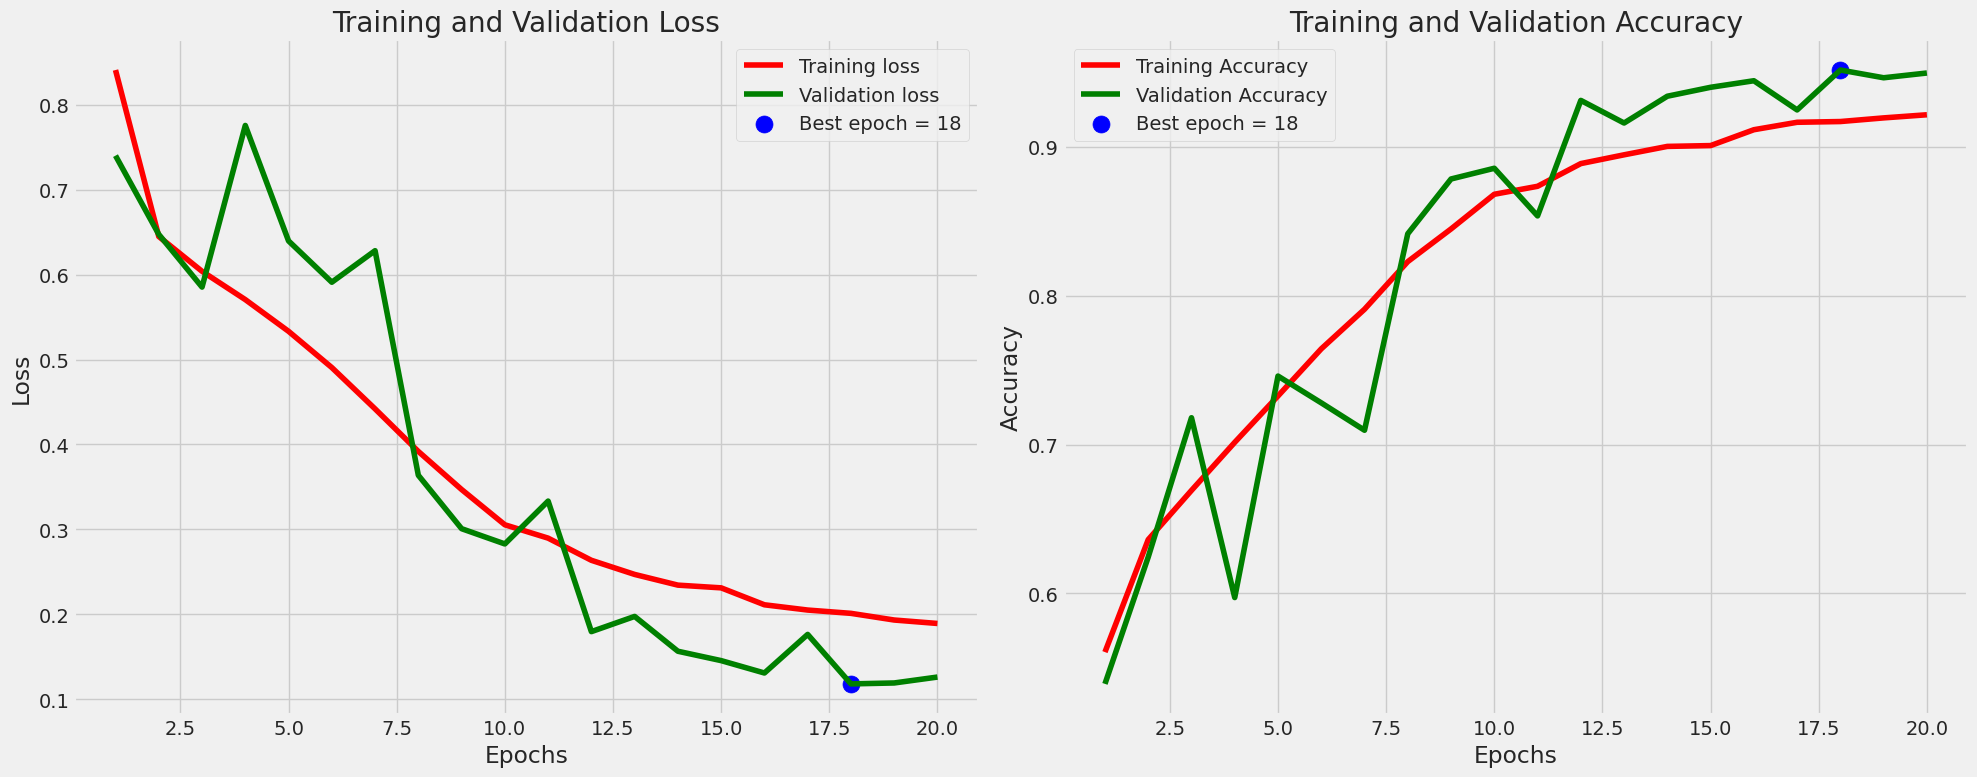

In [18]:
# ============================================================================
# CELL 12: Plot Training Results
# ============================================================================
print("\nPlotting training history...")
tr_plot(history, 0)

In [19]:
# ============================================================================
# CELL 13: Define Evaluation Function
# ============================================================================
def print_info(test_gen, preds, print_code, save_dir, subject):
    """Generate confusion matrix and classification report"""
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    
    for key, value in class_dict.items():
        new_dict[value] = key
    
    classes = list(new_dict.values())
    dict_as_text = str(new_dict)
    dict_name = subject + '-' + str(len(classes)) + '.txt'
    dict_path = os.path.join(save_dir, dict_name)
    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]
        
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors += 1
        
        y_pred.append(pred_index)
    
    if print_code != 0:
        if errors > 0:
            r = min(print_code, errors)
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format(
                'Filename', 'Predicted Class', 'True Class', 'Probability')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(
                    fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'With accuracy of 100% there are no errors to print'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
    
    if errors > 0:
        plot_bar = []
        plot_class = []
        
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)
                plot_class.append(value)
        
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        
        for i in range(len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
        
        plt.title('Errors by Class on Test Set')
        plt.show()
    
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    
    if len(classes) <= 30:
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        
        fig_width = max(8, int(length * 0.5))
        fig_height = max(8, int(length * 0.5))
        
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(length) + 0.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)


In [20]:
# ============================================================================
# CELL 14: Evaluate Model on Test Set
# ============================================================================
save_dir = './'
subject = 'Dog_Cat_FromScratch'

print("\nEvaluating model on test set...")
test_results = model.evaluate(test_gen, batch_size=test_batch_size, 
                               verbose=1, steps=test_steps, return_dict=True)

acc = test_results['accuracy'] * 100
loss = test_results['loss']

msg = f'Test Accuracy: {acc:.2f}%'
print_in_color(msg, (0, 255, 0), (55, 65, 80))
msg = f'Test Loss: {loss:.4f}'
print_in_color(msg, (0, 255, 0), (55, 65, 80))

# Save the model
save_id = str(model_name + '-' + subject + '-' + str(acc)[:str(acc).rfind('.') + 3] + '.keras')
save_loc = os.path.join(save_dir, save_id)
model.save(save_loc)
print(f"\nModel saved to: {save_loc}")


Evaluating model on test set...
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.9502 - loss: 0.1162
Test Accuracy: 94.28%

Test Loss: 0.1267


Model saved to: ./DogCat_Custom_CNN-Dog_Cat_FromScratch-94.27.keras



Generating predictions on test set...
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step
          Filename                Predicted Class                True Class           Probability   

        Cat/7480.jpg                    Dog                         Cat                 0.7892

       Cat/11281.jpg                    Dog                         Cat                 0.8233

        Dog/4104.jpg                    Cat                         Dog                 0.6401

        Dog/9414.jpg                    Cat                         Dog                 0.9751

        Dog/2687.jpg                    Cat                         Dog                 0.7536

        Dog/9076.jpg                    Cat                         Dog                 0.5535

        Dog/7816.jpg                    Cat                         Dog                 0.5295

        Dog/1541.jpg                    Cat                         Dog                 0.9727

        Dog/7810.jpg                    Cat       

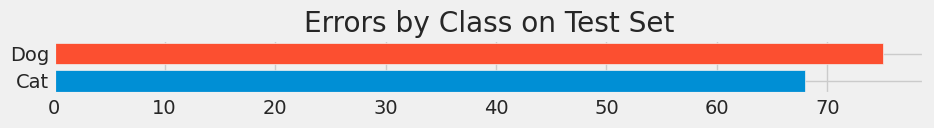

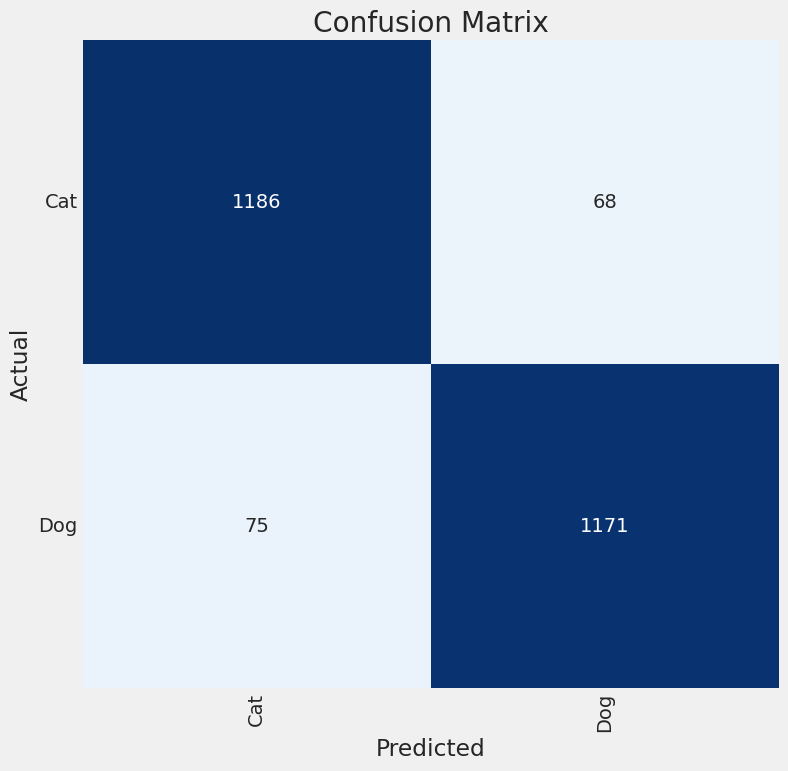

Classification Report:
----------------------
               precision    recall  f1-score   support

         Cat       0.94      0.95      0.94      1254
         Dog       0.95      0.94      0.94      1246

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



In [21]:
# ============================================================================
# CELL 15: Generate Predictions and Classification Report
# ============================================================================
print("\nGenerating predictions on test set...")
print_code = 10
preds = model.predict(test_gen, verbose=1)

print_info(test_gen, preds, print_code, save_dir, subject)
